In [111]:
import ast
import re
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns

In [2]:
data = []
with open('r2.txt', 'r') as f:
    for line in f:
        # Extract the dictionary part (the hyperparameters) from the line.
        dict_match = re.search(r"({.*?})", line)
        if dict_match:
            params = ast.literal_eval(dict_match.group(1))
        else:
            params = {}

        # Extract CV R^2 value.
        cv_match = re.search(r"CV R\^2\s+([-+]?\d*\.\d+|\d+)", line)
        cv_r2 = float(cv_match.group(1)) if cv_match else None

        # Extract MAE value.
        mae_match = re.search(r"MAE:\s+([-+]?\d*\.\d+|\d+)", line)
        mae = float(mae_match.group(1)) if mae_match else None

        # Add the extracted values to the parameters dictionary.
        params['CV_R2'] = cv_r2
        params['MAE'] = mae

        data.append(params)

# Create the DataFrame.
df = pd.DataFrame(data)

In [4]:
if 'reg_lin_dims' in df.columns:
    df['reg_lin_dims'] = df['reg_lin_dims'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

group_cols = ['d_model', 'n_attn_layer', 'idu_points', 'seq_len', 'attn_dropout', 'reg_lin_dims', 'epochs']

grouped_df = df.groupby(group_cols).agg(
    avg_CV_R2=('CV_R2', 'mean'),
    avg_MAE=('MAE', 'mean'),
    count=('CV_R2', 'size')
).reset_index()

In [8]:
grouped_df.sort_values(by='avg_MAE')

,d_model,n_attn_layer,idu_points,seq_len,attn_dropout,reg_lin_dims,epochs,avg_CV_R2,avg_MAE,count
1,32,3,2,256,0.410631,"(16, 1)",28,-0.469353,15.397904,5
11,80,2,4,144,0.206064,"(4, 1)",23,0.315376,15.436661,3
10,64,3,2,144,0.448618,"(4, 1)",30,-1.427002,15.545087,5
4,32,3,8,400,0.050824,"(1,)",14,-1.617924,15.581099,5
0,32,1,6,400,0.143923,"(1,)",26,-2.043155,15.680569,5
5,64,1,3,400,0.172824,"(4, 1)",13,-0.888293,15.698577,5
12,80,2,6,400,0.293147,"(16, 1)",16,-2.374155,15.755999,5
13,80,2,8,400,0.134749,"(1,)",5,-0.604896,15.873282,5
8,64,2,6,256,0.050988,"(4, 1)",8,-1.188897,15.887019,5
9,64,2,7,100,0.347978,"(1,)",9,-0.788458,16.166570,5


In [2]:
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from model.estimator import GARegressor
import time
import numpy as np
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold
import pickle

with open("../grid_large_std.pkl", "rb") as f:
    grid = pickle.load(f)

def calculate_midpoint(value):
    if value is None or value == "None":
        return np.nan
    try:
        if '-' in value:
            parts = value.split('-')
            # Convert each part to float after stripping whitespace
            low = float(parts[0].strip())
            high = float(parts[1].strip())
            return (low + high) / 2
        else:
            return float(value)
    except Exception:
        return np.nan

grid["Coarse_mid"] = grid.PercentCoarse.apply(calculate_midpoint)
numeric_cols = grid.select_dtypes(include=[np.number]).columns
filtered_numeric_cols = numeric_cols.difference(['latitude', 'longitude', 'Coarse_mid']).to_numpy()
tab_x = list(filtered_numeric_cols)
tab_l = ['latitude', 'longitude']
tab_y = ["Coarse_mid"]
df = grid[~grid.Coarse_mid.isna()]
X, y = df[tab_x + tab_l], df[tab_y]

/global/home/users/nross/.local/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [3]:
mini = pd.concat([X[tab_l], y], axis=1)

In [4]:
cvhm = pd.read_csv("cvhm_PC.csv")[["X_COORD", "Y_COORD", "PC_D25"]]

In [5]:
import geopandas as gpd

In [6]:
cvhm_gdf = gpd.GeoDataFrame(cvhm, geometry=gpd.points_from_xy(cvhm.X_COORD, cvhm.Y_COORD))

crs_albers = {
    'proj': 'aea',           # Albers Equal Area Conic projection
    'lat_1': 29.5,           # First standard parallel
    'lat_2': 45.5,           # Second standard parallel
    'lat_0': 23.0,           # Latitude of origin
    'lon_0': -120.0,         # Central meridian
    'x_0': 0,                # False easting
    'y_0': 0,                # False northing
    'datum': 'NAD83',        # Datum
    'units': 'm'             # Linear unit in meters
}

cvhm_gdf.set_crs(crs_albers, inplace=True)

,X_COORD,Y_COORD,PC_D25,geometry
0,-193663.0,1964850.0,25.29,POINT (-193663 1964850)
1,-195623.0,1961830.0,30.11,POINT (-195623 1961830)
2,-194235.0,1962650.0,26.48,POINT (-194235 1962650)
3,-192847.0,1963460.0,23.13,POINT (-192847 1963460)
4,-191460.0,1964280.0,16.90,POINT (-191460 1964280)
...,...,...,...,...
20528,107958.0,1324510.0,43.18,POINT (107958 1324510)
20529,109345.0,1325320.0,42.67,POINT (109345 1325320)
20530,110733.0,1326140.0,41.85,POINT (110733 1326140)
20531,104611.0,1320680.0,42.11,POINT (104611 1320680)


In [7]:
mini_gdf = gpd.GeoDataFrame(mini, geometry=gpd.points_from_xy(mini.longitude, mini.latitude))
mini_gdf.set_crs(epsg=4326, inplace=True)
mini_gdf = mini_gdf.to_crs(cvhm_gdf.crs)

In [8]:
result = gpd.sjoin_nearest(mini_gdf, 
                           cvhm_gdf[['PC_D25', 'geometry']], 
                           how='left', 
                           distance_col='distance')

In [9]:
np.mean(abs(result[result["distance"] < 500].Coarse_mid - result[result["distance"] < 500].PC_D25))

19.026110869565215

In [10]:
geoAgg = pd.read_csv("eighty_train_v1.csv")

In [11]:
geoAgg_gdf = gpd.GeoDataFrame(geoAgg, geometry=gpd.points_from_xy(geoAgg.longitude, geoAgg.latitude))
geoAgg_gdf.set_crs("EPSG:4326", inplace=True)

,latitude,longitude,Coarse_mid,pred,geometry
0,40.141374,-122.559177,65.0,41.578613,POINT (-122.55918 40.14137)
1,40.127639,-122.550194,55.0,38.366959,POINT (-122.55019 40.12764)
2,40.134507,-122.550194,65.0,65.313339,POINT (-122.55019 40.13451)
3,40.141374,-122.550194,75.0,40.095409,POINT (-122.55019 40.14137)
4,40.148241,-122.550194,55.0,39.879368,POINT (-122.55019 40.14824)
...,...,...,...,...,...
15340,38.508477,-121.103906,5.0,36.586380,POINT (-121.10391 38.50848)
15341,38.515507,-121.103906,25.0,37.834316,POINT (-121.10391 38.51551)
15342,38.522535,-121.103906,55.0,38.443970,POINT (-121.10391 38.52253)
15343,38.529563,-121.103906,65.0,63.516407,POINT (-121.10391 38.52956)


In [12]:
comparison = gpd.sjoin_nearest(result.drop(columns=["index_right"]), 
                           geoAgg_gdf[['pred', 'geometry']].to_crs(result.crs), 
                           how='left', 
                           distance_col='distance_geoAgg')

In [13]:
np.mean(abs(comparison.Coarse_mid - comparison.pred))

14.32703144634613

In [14]:
np.mean(abs(comparison[comparison["distance"] < 1000].Coarse_mid - comparison[comparison["distance"] < 1000].pred))

14.269355634651683

In [15]:
np.mean(abs(comparison.Coarse_mid - comparison.pred) < abs(comparison.Coarse_mid - comparison.PC_D25))

0.6296513522319974

In [16]:
np.mean(abs(comparison[comparison["distance"] < 1000].Coarse_mid - comparison[comparison["distance"] < 1000].pred)
        < abs(comparison[comparison["distance"] < 1000].Coarse_mid - comparison[comparison["distance"] < 1000].PC_D25))

0.629560915275201

In [17]:
a = comparison[comparison["distance"] < 500].copy()
a = a[abs(a.Coarse_mid - a.pred) < abs(a.Coarse_mid - a.PC_D25)]
np.mean(abs(abs(a.Coarse_mid - a.pred) - abs(a.Coarse_mid - a.PC_D25)))

13.576656086687732

In [18]:
b = comparison[comparison["distance"] < 500].copy()
b = b[abs(b.Coarse_mid - b.pred) > abs(b.Coarse_mid - b.PC_D25)]
np.mean(abs(abs(b.Coarse_mid - b.pred) - abs(b.Coarse_mid - b.PC_D25)))

9.955847415648654

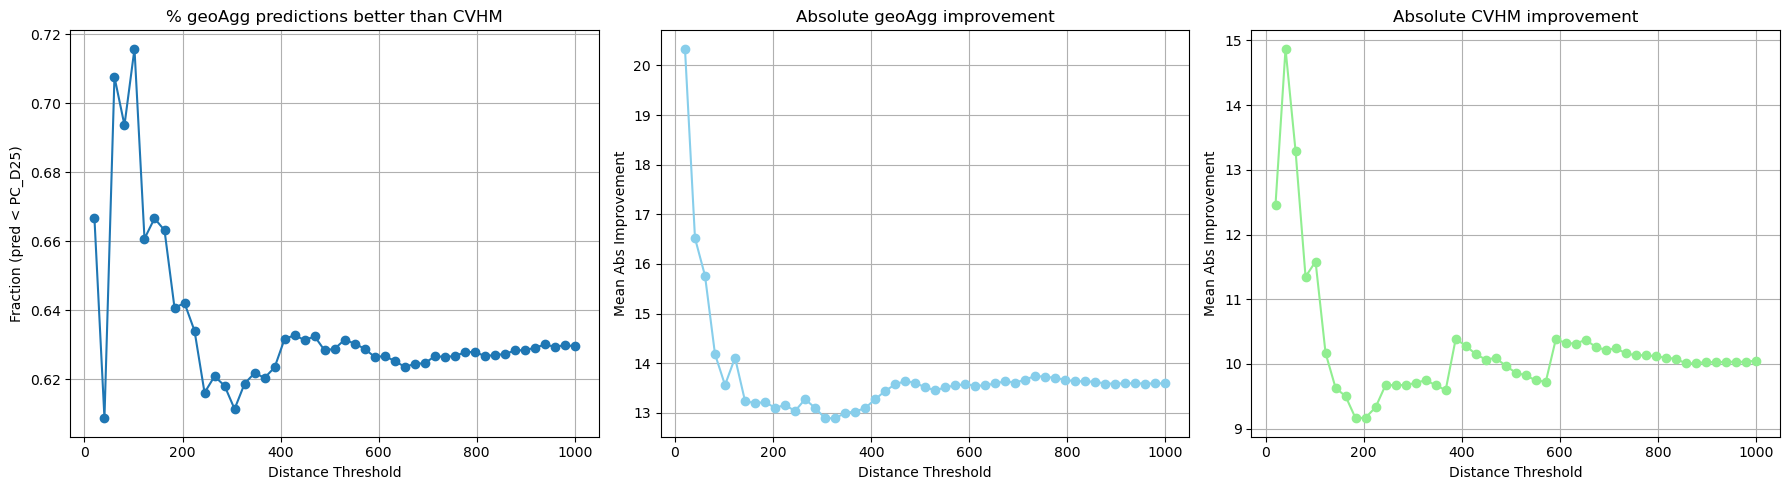

In [19]:
thresholds = np.linspace(0, 1000, 50)

# Initialize lists to store the computed metrics for each threshold
main_metric = []  # Fraction metric for the entire subset
metric_a = []     # Mean abs difference for Group A (pred error < PC_D25 error)
metric_b = []     # Mean abs difference for Group B (pred error > PC_D25 error)

# Loop over each threshold and compute the metrics
for t in thresholds:
    # Subset of data with distance less than the current threshold
    subset = comparison[comparison["distance"] < t]
    
    # Compute the main error metric: fraction where |Coarse_mid - pred| < |Coarse_mid - PC_D25|
    if len(subset) > 0:
        main_val = np.mean(np.abs(subset.Coarse_mid - subset.pred) < np.abs(subset.Coarse_mid - subset.PC_D25))
    else:
        main_val = np.nan
    main_metric.append(main_val)
    
    # For Group A: rows where pred is closer than PC_D25
    group_a = subset[np.abs(subset.Coarse_mid - subset.pred) < np.abs(subset.Coarse_mid - subset.PC_D25)]
    if len(group_a) > 0:
        a_val = np.mean(np.abs(np.abs(group_a.Coarse_mid - group_a.pred) - np.abs(group_a.Coarse_mid - group_a.PC_D25)))
    else:
        a_val = np.nan
    metric_a.append(a_val)
    
    # For Group B: rows where pred is farther than PC_D25
    group_b = subset[np.abs(subset.Coarse_mid - subset.pred) > np.abs(subset.Coarse_mid - subset.PC_D25)]
    if len(group_b) > 0:
        b_val = np.mean(np.abs(np.abs(group_b.Coarse_mid - group_b.pred) - np.abs(group_b.Coarse_mid - group_b.PC_D25)))
    else:
        b_val = np.nan
    metric_b.append(b_val)

# Create three side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Main Error Metric vs. Distance Threshold
axes[0].plot(thresholds, main_metric, marker='o')
axes[0].set_xlabel("Distance Threshold")
axes[0].set_ylabel("Fraction (pred < PC_D25)")
axes[0].set_title("% geoAgg predictions better than CVHM")
axes[0].grid(True)

# Plot 2: Group A Metric vs. Distance Threshold
axes[1].plot(thresholds, metric_a, marker='o', color='skyblue')
axes[1].set_xlabel("Distance Threshold")
axes[1].set_ylabel("Mean Abs Improvement")
axes[1].set_title("Absolute geoAgg improvement")
axes[1].grid(True)

# Plot 3: Group B Metric vs. Distance Threshold
axes[2].plot(thresholds, metric_b, marker='o', color='lightgreen')
axes[2].set_xlabel("Distance Threshold")
axes[2].set_ylabel("Mean Abs Improvement")
axes[2].set_title("Absolute CVHM improvement")
axes[2].grid(True)

plt.tight_layout()
plt.show()

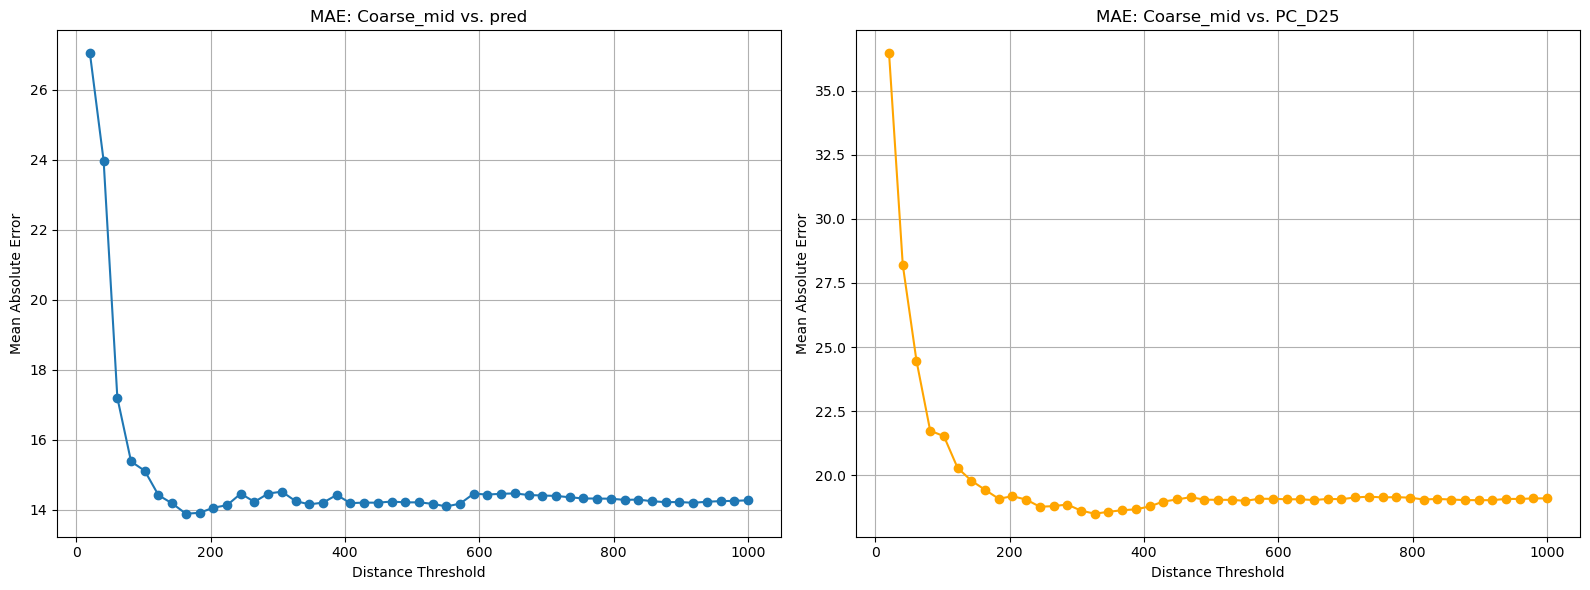

In [20]:
mae_pred = []      # For MAE between Coarse_mid and pred
mae_pc_d25 = []    # For MAE between Coarse_mid and PC_D25

# Loop over each threshold to compute the MAEs
for t in thresholds:
    subset = comparison[comparison["distance"] < t]
    if len(subset) > 0:
        mae_pred_value = np.mean(np.abs(subset.Coarse_mid - subset.pred))
        mae_pc_value = np.mean(np.abs(subset.Coarse_mid - subset.PC_D25))
    else:
        mae_pred_value = np.nan
        mae_pc_value = np.nan
    mae_pred.append(mae_pred_value)
    mae_pc_d25.append(mae_pc_value)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Coarse_mid vs. pred
axes[0].plot(thresholds, mae_pred, marker='o')
axes[0].set_xlabel("Distance Threshold")
axes[0].set_ylabel("Mean Absolute Error")
axes[0].set_title("MAE: Coarse_mid vs. pred")
axes[0].grid(True)

# Plot for Coarse_mid vs. PC_D25
axes[1].plot(thresholds, mae_pc_d25, marker='o', color='orange')
axes[1].set_xlabel("Distance Threshold")
axes[1].set_ylabel("Mean Absolute Error")
axes[1].set_title("MAE: Coarse_mid vs. PC_D25")
axes[1].grid(True)

plt.tight_layout()
plt.show()

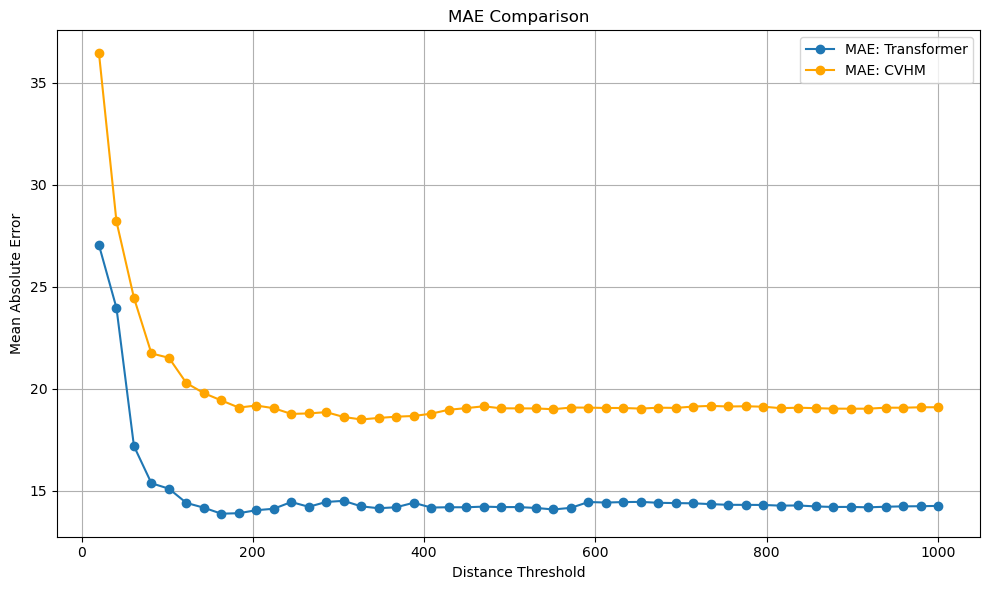

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresholds, mae_pred, marker='o', label='MAE: Transformer')
ax.plot(thresholds, mae_pc_d25, marker='o', label='MAE: CVHM', color='orange')

ax.set_xlabel("Distance Threshold")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("MAE Comparison")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

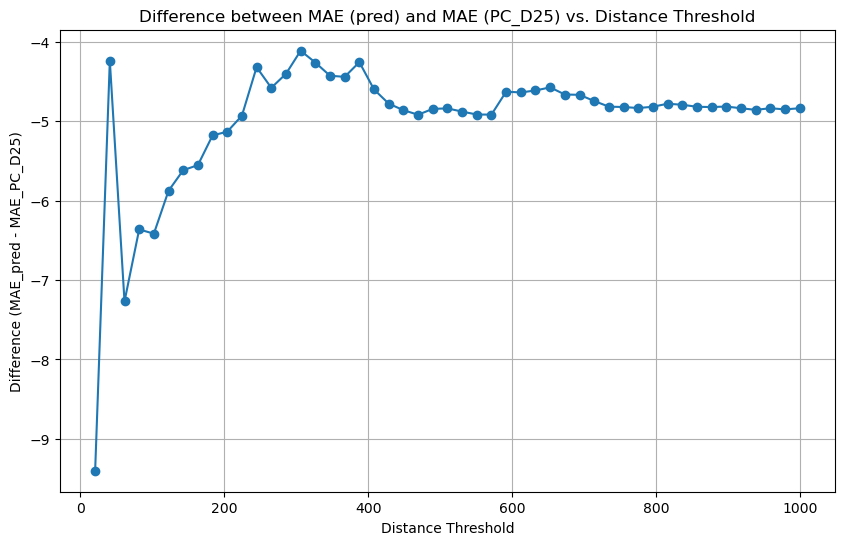

In [22]:
mae_diff = []  # This will store MAE_pred - MAE_PC_D25 for each threshold

# Loop over each threshold and compute the difference
for t in thresholds:
    subset = comparison[comparison["distance"] < t]
    if len(subset) > 0:
        mae_pred = np.mean(np.abs(subset.Coarse_mid - subset.pred))
        mae_pc_d25 = np.mean(np.abs(subset.Coarse_mid - subset.PC_D25))
        diff = mae_pred - mae_pc_d25
    else:
        diff = np.nan
    mae_diff.append(diff)

# Plot the difference as a function of the distance threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mae_diff, marker='o')
plt.xlabel("Distance Threshold")
plt.ylabel("Difference (MAE_pred - MAE_PC_D25)")
plt.title("Difference between MAE (pred) and MAE (PC_D25) vs. Distance Threshold")
plt.grid(True)
plt.show()

In [23]:
comparison["pred"] = np.clip(comparison['pred'], 0, 100)

In [24]:
comparison.drop(columns=["index_right"], inplace=True, errors="ignore")
comparison["buffer_10km"] = comparison.geometry.buffer(10000)

buffers_gdf = comparison.copy()
buffers_gdf = buffers_gdf.set_geometry("buffer_10km")

joined = gpd.sjoin(
    buffers_gdf,
    comparison,
    how="left",
    predicate="intersects",
)
grouped = joined.groupby(["latitude_left", "longitude_left"])[["Coarse_mid_right", "PC_D25_right", "pred_right"]].mean()

comparison = comparison.merge(
    grouped,
    left_on=["latitude", "longitude"],
    right_on=["latitude_left", "longitude_left"],
    how="left",
    suffixes=("","_mean")
)

In [25]:
np.mean(abs(comparison.Coarse_mid_right - comparison.pred_right))

4.348775981926804

In [26]:
np.mean(abs(comparison.Coarse_mid_right - comparison.PC_D25_right))

10.201994965902143

In [27]:
np.mean(abs(comparison[comparison["distance"] < 1000].Coarse_mid_right - comparison[comparison["distance"] < 1000].PC_D25_right))

10.218233449229155

In [28]:
comp_copy = comparison.copy()
comp_copy["pred"] = np.clip(comp_copy['pred'], 0, 100)

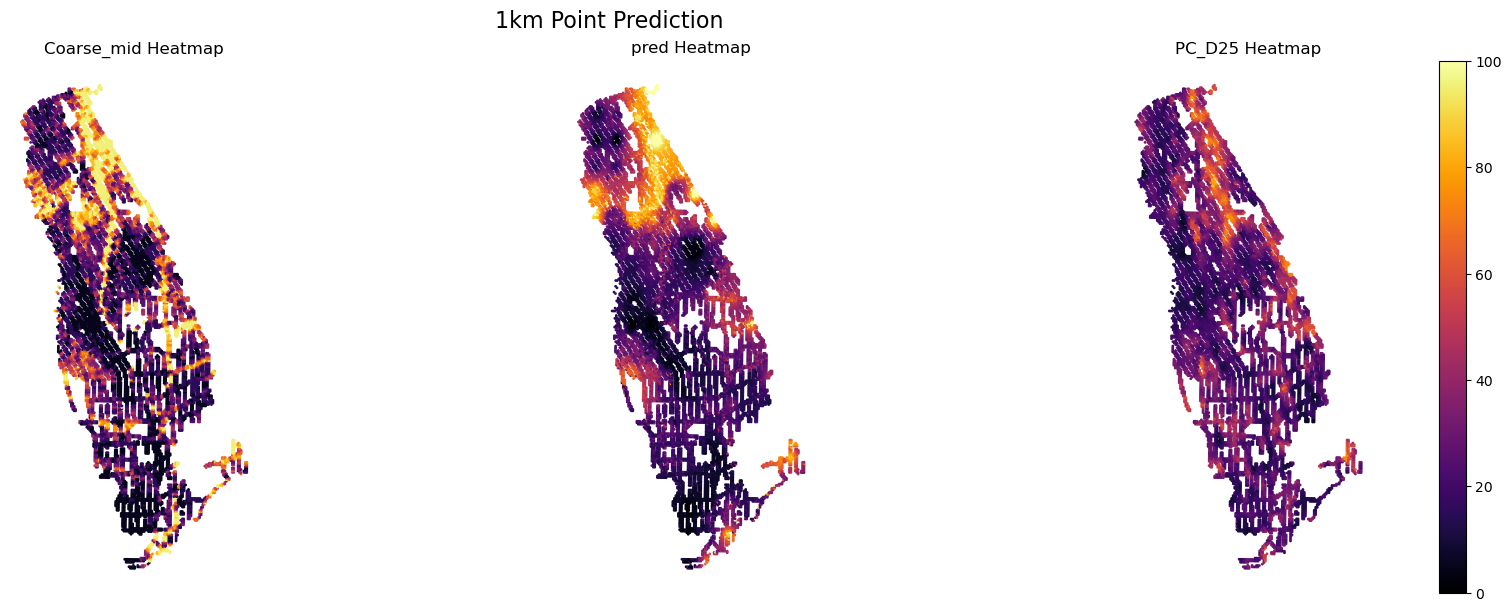

In [29]:
import matplotlib as mpl
columns = ["Coarse_mid", "pred", "PC_D25"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), constrained_layout=True)

for ax, col in zip(axes, columns):
    comp_copy.plot(
        ax=ax, 
        column=col, 
        cmap='inferno', 
        markersize=1, 
        vmin=0, vmax=100
    )
    ax.set_title(f"{col} Heatmap")
    ax.set_axis_off()

norm = mpl.colors.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])

fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

fig.suptitle("1km Point Prediction", fontsize=16)
plt.show()

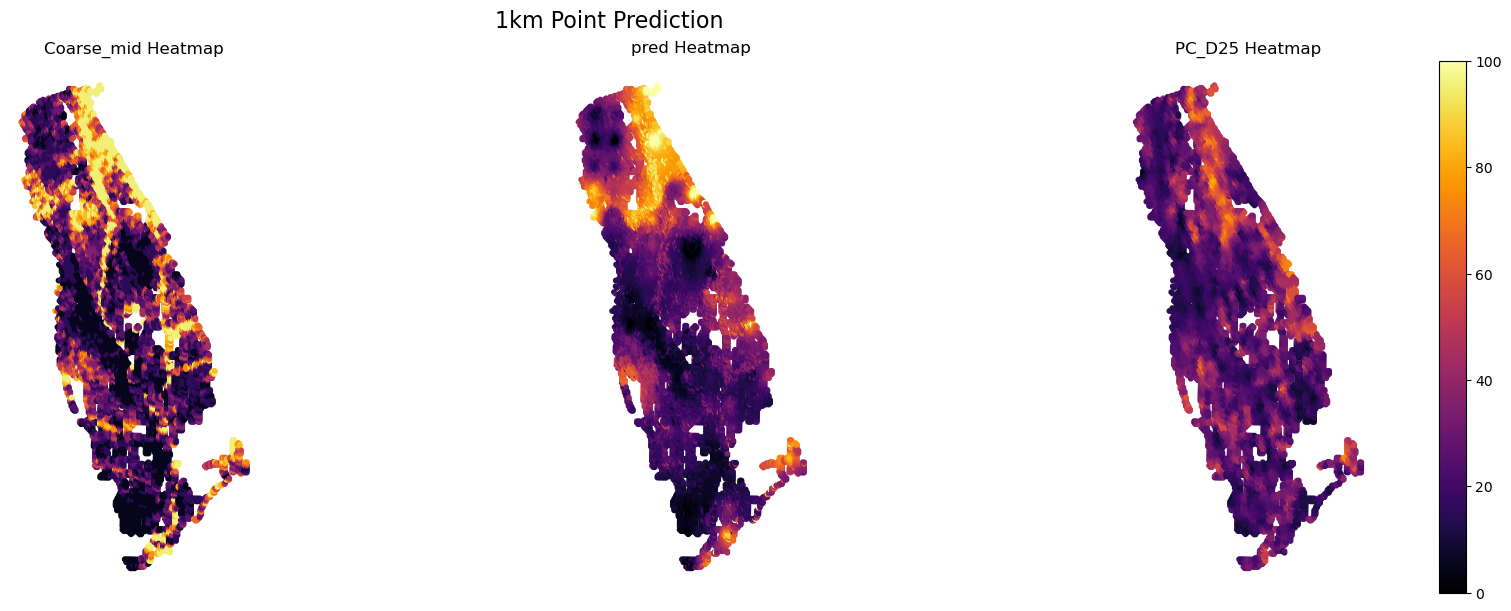

In [30]:
columns = ["Coarse_mid", "pred", "PC_D25"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), constrained_layout=True)

for ax, col in zip(axes, columns):
    comp_copy.plot(
        ax=ax, 
        column=col, 
        cmap='inferno', 
        markersize=10, 
        vmin=0, vmax=100
    )
    ax.set_title(f"{col} Heatmap")
    ax.set_axis_off()

norm = mpl.colors.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])

fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

fig.suptitle("1km Point Prediction", fontsize=16)
plt.show()

In [31]:
comparison[["Coarse_mid", "pred", "PC_D25"]].describe()

,Coarse_mid,pred,PC_D25
count,15345.000000,15345.000000,15345.000000
mean,34.386771,31.414107,28.733591
std,28.806564,22.959278,13.818175
min,5.000000,0.000000,4.430000
25%,15.000000,14.526834,18.650000
50%,25.000000,24.368124,25.460000
75%,55.000000,42.962940,36.150000
max,95.000000,100.000000,82.880000


In [32]:
np.mean(abs(comp_copy.Coarse_mid - comp_copy.pred))

14.016431337837755

In [33]:
np.mean(abs(comp_copy.Coarse_mid_right - comp_copy.pred_right))

4.348775981926804

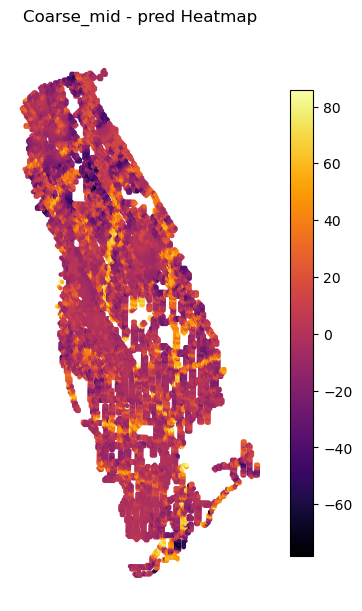

In [34]:
comp_copy['diff'] = comp_copy['Coarse_mid'] - comp_copy['pred']

# Create a single subplot for the difference heatmap
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

# Plot the difference using the 'inferno' colormap
comp_copy.plot(
    ax=ax,
    column='diff',
    cmap='inferno',
    markersize=5
)
ax.set_title("Coarse_mid - pred Heatmap")
ax.set_axis_off()

vmin = comp_copy['diff'].min()
vmax = comp_copy['diff'].max()

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])

fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.show()

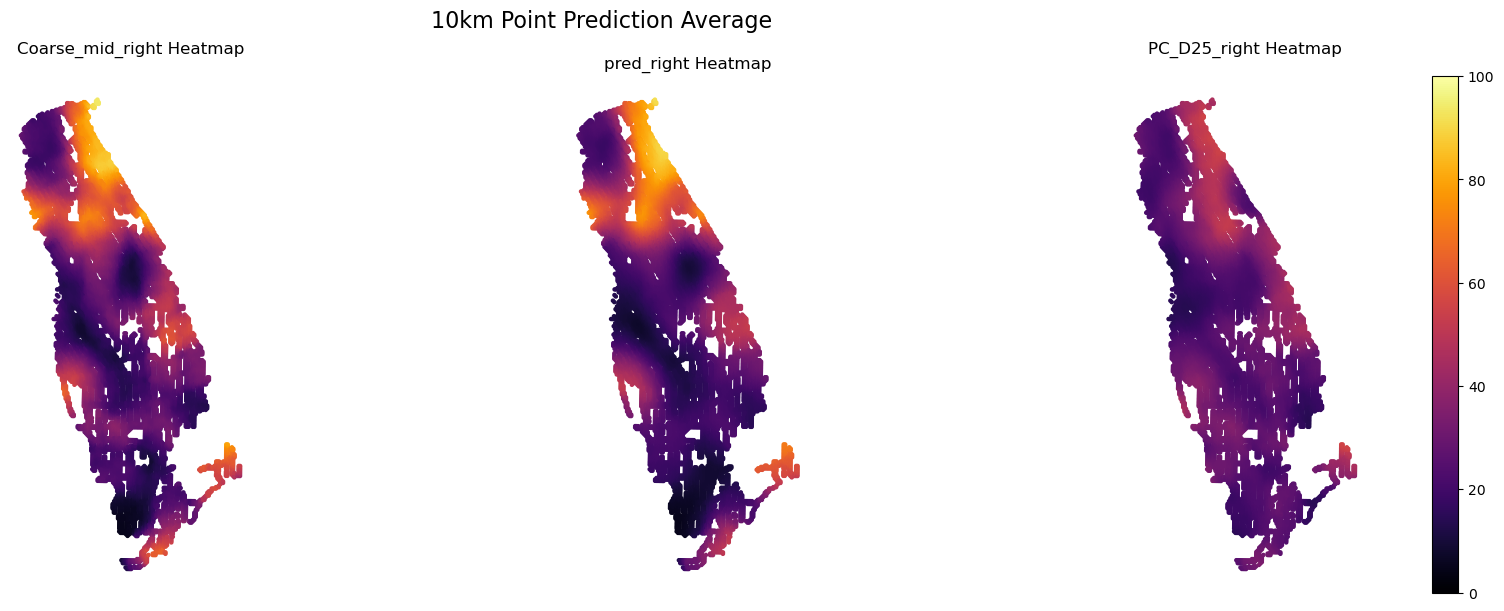

In [35]:
columns = ["Coarse_mid_right", "pred_right", "PC_D25_right"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), constrained_layout=True)

for ax, col in zip(axes, columns):
    comp_copy.plot(
        ax=ax, 
        column=col, 
        cmap='inferno', 
        markersize=5, 
        vmin=0, vmax=100
    )
    ax.set_title(f"{col} Heatmap")
    ax.set_axis_off()

norm = mpl.colors.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])

fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

fig.suptitle("10km Point Prediction Average", fontsize=16)
plt.show()

In [54]:
test_set = pd.read_csv("test_set_v1_train.csv")

In [56]:
test_set = gpd.GeoDataFrame(test_set, geometry=gpd.points_from_xy(test_set.longitude, test_set.latitude))
test_set.set_crs(epsg=4326, inplace=True)
test_set = test_set.to_crs(cvhm_gdf.crs)

In [59]:
test_compare = gpd.sjoin_nearest(test_set, 
                           cvhm_gdf[['PC_D25', 'geometry']], 
                           how='left', 
                           distance_col='distance')

In [61]:
np.mean(abs(test_compare.Coarse_mid - test_compare.pred))

16.46182874222849

In [62]:
np.mean(abs(test_compare.Coarse_mid - test_compare.PC_D25))

18.878862821766045

In [85]:
comp_copy["trans_improve"] = - ((comp_copy.Coarse_mid - comp_copy.pred) - (comp_copy.Coarse_mid - comp_copy.PC_D25))

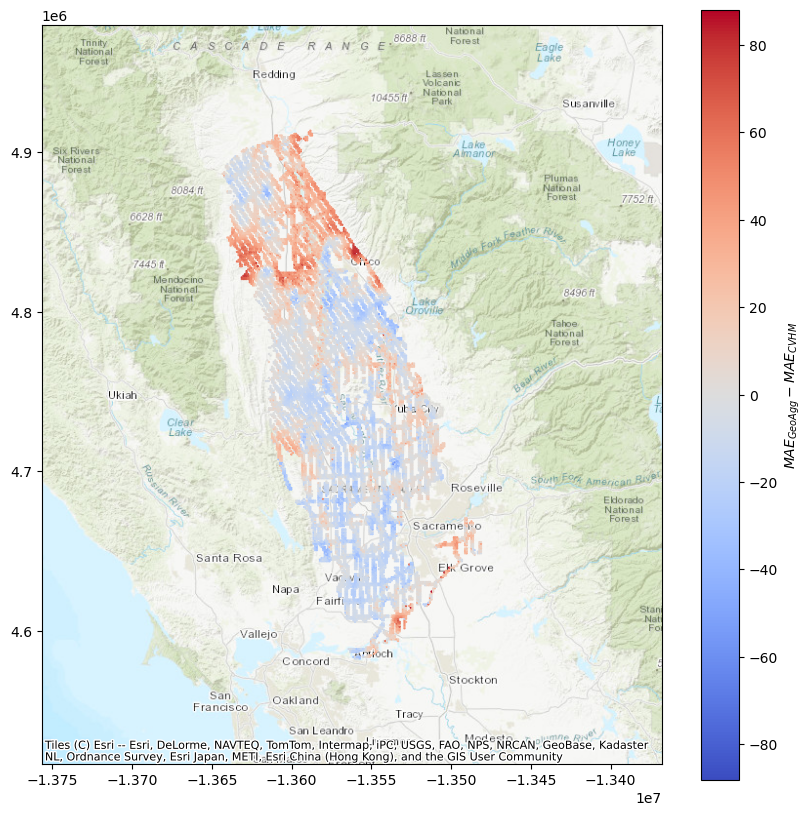

In [91]:
comp_copy = comp_copy.to_crs(epsg=3857)
centering = max(abs(comp_copy.trans_improve.min()), comp_copy.trans_improve.max())
fig, ax = plt.subplots(figsize=(10, 10))
comp_copy.plot(
    column='trans_improve',
    markersize=0.5,
    cmap='coolwarm',
    ax=ax,
    legend=True,
    vmin=-centering,
    vmax=centering,
    legend_kwds={
                'label':"$MAE_{GeoAgg} - MAE_{CVHM}$"}
)

xmin, ymin, xmax, ymax = comp_copy.total_bounds
x_buffer = (xmax - xmin) * 0.7
y_buffer = (ymax - ymin) * 0.2

ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
ax.set_ylim(ymin - y_buffer, ymax + y_buffer)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)
plt.show()

In [102]:
comp_copy["trans_10k_improve"] = - ((comp_copy.Coarse_mid_right - comp_copy.pred_right) 
                                    - (comp_copy.Coarse_mid_right - comp_copy.PC_D25_right))

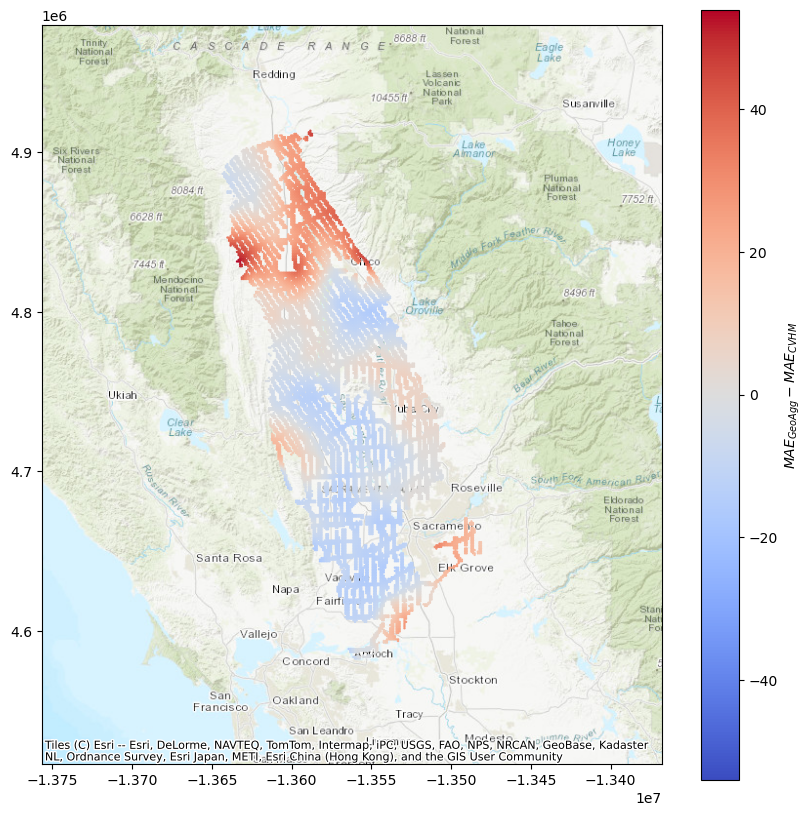

In [105]:
comp_copy = comp_copy.to_crs(epsg=3857)
centering = max(abs(comp_copy.trans_10k_improve.min()), comp_copy.trans_10k_improve.max())
fig, ax = plt.subplots(figsize=(10, 10))
comp_copy.plot(
    column='trans_10k_improve',
    markersize=0.5,
    cmap='coolwarm',
    ax=ax,
    legend=True,
    vmin=-centering,
    vmax=centering,
    legend_kwds={
                'label':"$MAE_{GeoAgg} - MAE_{CVHM}$"}
)

xmin, ymin, xmax, ymax = comp_copy.total_bounds
x_buffer = (xmax - xmin) * 0.7
y_buffer = (ymax - ymin) * 0.2

ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
ax.set_ylim(ymin - y_buffer, ymax + y_buffer)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)
plt.show()

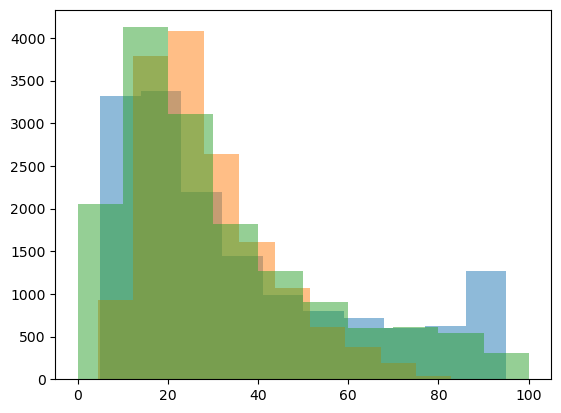

In [110]:
plt.hist(comp_copy.Coarse_mid, bins=10, alpha=0.5)
plt.hist(comp_copy.PC_D25, bins=10, alpha=0.5)
plt.hist(comp_copy.pred, bins=10, alpha=0.5)
plt.show()

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


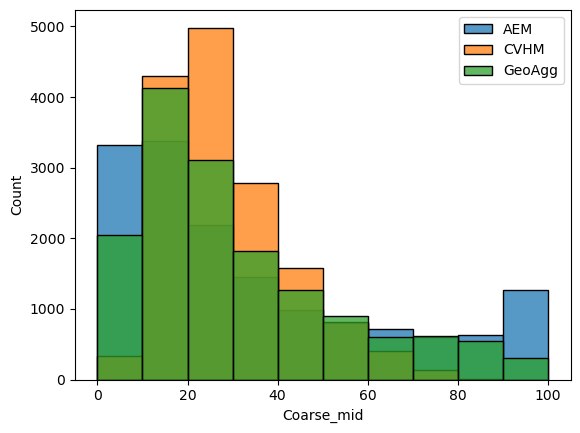

In [123]:
a = comp_copy
bins = np.arange(0, 110, 10)
sns.histplot(a.Coarse_mid, label="AEM", bins=bins)
sns.histplot(a.PC_D25, label="CVHM", bins=bins)
sns.histplot(a.pred, label="GeoAgg", bins=bins)

plt.legend()
plt.show()

In [134]:
from scipy.stats import wasserstein_distance

Earth Mover's Distance (Wasserstein Distance): 5.895207365893821
Jensen-Shannon Distance: 0.14393825004997562
Histogram Intersection (Area): 0.8417725643532097


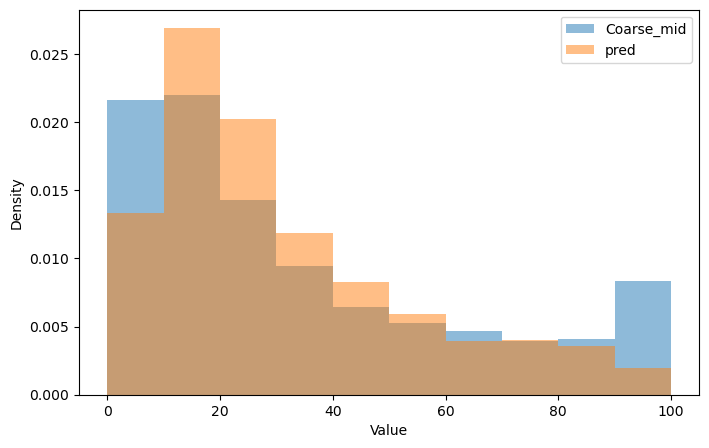

In [139]:
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon

# Assume comp_copy is your pandas DataFrame that contains the columns 'Coarse_mid' and 'pred'
# For example:
# comp_copy = pd.read_csv('your_data.csv')

# Step 1: Define common bins for the histograms based on the overall data range
n_bins = 10
min_val = min(comp_copy['Coarse_mid'].min(), comp_copy['pred'].min())
max_val = max(comp_copy['Coarse_mid'].max(), comp_copy['pred'].max())
bins = np.linspace(min_val, max_val, n_bins + 1)

# Step 2: Compute the histograms for each column (using density=True so the histograms sum to 1)
hist_coarse, _ = np.histogram(comp_copy['Coarse_mid'], bins=bins, density=True)
hist_pred, _   = np.histogram(comp_copy['pred'], bins=bins, density=True)

# Step 3: Compute similarity metrics

# 3a. Earth Mover’s Distance (Wasserstein Distance) directly on the raw data.
emd = wasserstein_distance(comp_copy['Coarse_mid'], comp_copy['pred'])
print("Earth Mover's Distance (Wasserstein Distance):", emd)

# 3b. Jensen-Shannon Distance between the two histograms.
# Note: jensenshannon returns the square root of the divergence.
js_distance = jensenshannon(hist_coarse, hist_pred)
print("Jensen-Shannon Distance:", js_distance)

# 3c. Histogram Intersection:
# Multiply the minimum values of the two histograms in each bin by the bin width
bin_width = np.diff(bins)
histogram_intersection = np.sum(np.minimum(hist_coarse, hist_pred) * bin_width)
print("Histogram Intersection (Area):", histogram_intersection)

# Step 4: Visualize the histograms for a qualitative comparison
plt.figure(figsize=(8, 5))
plt.hist(comp_copy['Coarse_mid'], bins=bins, alpha=0.5, label='Coarse_mid', density=True)
plt.hist(comp_copy['pred'], bins=bins, alpha=0.5, label='pred', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

Earth Mover's Distance (Wasserstein Distance): 12.213689149560118
Jensen-Shannon Distance: 0.27684004518366984
Histogram Intersection (Area): 0.699446073639622


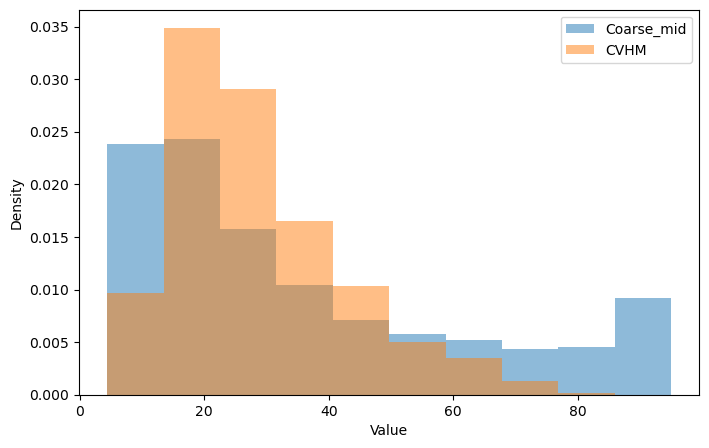

In [138]:
n_bins = 10
min_val = min(comp_copy['Coarse_mid'].min(), comp_copy['PC_D25'].min())
max_val = max(comp_copy['Coarse_mid'].max(), comp_copy['PC_D25'].max())
bins = np.linspace(min_val, max_val, n_bins + 1)

# Step 2: Compute the histograms for each column (using density=True so the histograms sum to 1)
hist_coarse, _ = np.histogram(comp_copy['Coarse_mid'], bins=bins, density=True)
hist_pred, _   = np.histogram(comp_copy['PC_D25'], bins=bins, density=True)

# Step 3: Compute similarity metrics

# 3a. Earth Mover’s Distance (Wasserstein Distance) directly on the raw data.
emd = wasserstein_distance(comp_copy['Coarse_mid'], comp_copy['PC_D25'])
print("Earth Mover's Distance (Wasserstein Distance):", emd)

# 3b. Jensen-Shannon Distance between the two histograms.
# Note: jensenshannon returns the square root of the divergence.
js_distance = jensenshannon(hist_coarse, hist_pred)
print("Jensen-Shannon Distance:", js_distance)

# 3c. Histogram Intersection:
# Multiply the minimum values of the two histograms in each bin by the bin width
bin_width = np.diff(bins)
histogram_intersection = np.sum(np.minimum(hist_coarse, hist_pred) * bin_width)
print("Histogram Intersection (Area):", histogram_intersection)

# Step 4: Visualize the histograms for a qualitative comparison
plt.figure(figsize=(8, 5))
plt.hist(comp_copy['Coarse_mid'], bins=bins, alpha=0.5, label='Coarse_mid', density=True)
plt.hist(comp_copy['PC_D25'], bins=bins, alpha=0.5, label='CVHM', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [140]:
ones = pd.read_csv("ones_test.csv")

In [146]:
big_gap = grid[~grid.PercentCoarse.isna()]

In [159]:
combined_geom = big_gap.unary_union
centroid = combined_geom.centroid
print("Centroid (in the CRS of big_gap):", centroid)
buffer_circle = centroid.buffer(30000)
big_gap_chunk = big_gap[~big_gap.geometry.intersects(buffer_circle)]

/tmp/ipykernel_1519092/3645124944.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_geom = big_gap.unary_union


Centroid (in the CRS of big_gap): POINT (-13571789.509909496 4755562.7486291705)


<Axes: >

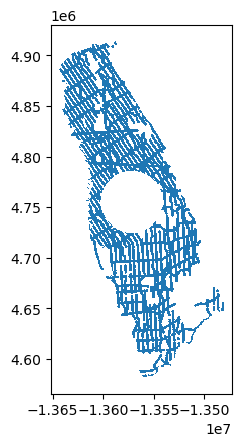

In [160]:
big_gap_chunk.plot()